# Movie Recommendation System: TF-IDF vs KNN Comparison

## Project Overview
This project implements and compares two content-based movie recommendation methods:
1. **TF-IDF with Cosine Similarity** - Statistical text vectorization approach
2. **KNN (K-Nearest Neighbors)** - Distance-based similarity approach

Both methods use movie metadata (genres, keywords, cast, director, overview) to find similar movies.


In [1]:
# Cell 1 — Import Libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import ast
import pickle
import time
from pathlib import Path

# Text and vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors

# ML models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Try to import XGBoost; fallback to HistGradientBoosting
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier
    XGB_AVAILABLE = False

print("✓ All libraries imported successfully")


✓ All libraries imported successfully


In [2]:
# Cell 2 — Load and Merge Data
movies_csv = "tmdb_5000_movies.csv"
credits_csv = "tmdb_5000_credits.csv"

print(f"Loading {movies_csv}...")
movies_raw = pd.read_csv(movies_csv)
print(f"Loading {credits_csv}...")
credits_raw = pd.read_csv(credits_csv)

# Merge on title
print("Merging datasets...")
movies_full = movies_raw.merge(credits_raw, on="title")

print(f"✓ Dataset loaded: {movies_full.shape[0]} movies, {movies_full.shape[1]} columns")
print(f"✓ Available columns: {list(movies_full.columns)[:10]}...")


Loading tmdb_5000_movies.csv...
Loading tmdb_5000_credits.csv...
Merging datasets...
✓ Dataset loaded: 4809 movies, 23 columns
✓ Available columns: ['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies']...


In [3]:
# Cell 3 — Parse JSON Metadata and Build Feature Tags

df = movies_full.copy()
df = df[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew', 'id', 'budget', 'popularity', 'runtime', 'revenue', 'vote_average', 'vote_count']]

# Remove rows with missing critical fields
df.dropna(subset=['overview', 'genres', 'cast', 'crew'], inplace=True)
print(f"After dropping nulls: {df.shape[0]} movies")

# Helper functions to parse TMDB JSON
def parse_names(obj):
    """Extract names from TMDB list-of-dicts JSON"""
    L = []
    try:
        for i in ast.literal_eval(obj):
            L.append(i.get('name', ''))
    except:
        pass
    return L

def get_top3_cast(obj):
    """Extract top 3 cast members"""
    L = []
    counter = 0
    try:
        for i in ast.literal_eval(obj):
            if counter < 3:
                L.append(i.get('name', ''))
                counter += 1
    except:
        pass
    return L

def get_director(obj):
    """Extract director from crew"""
    try:
        for i in ast.literal_eval(obj):
            if i.get('job') == 'Director':
                return i.get('name', '')
    except:
        pass
    return ''

print("Parsing JSON metadata...")
df['genres'] = df['genres'].apply(parse_names)
df['keywords'] = df['keywords'].apply(parse_names)
df['cast'] = df['cast'].apply(get_top3_cast)
df['director'] = df['crew'].apply(get_director)

# Clean spaces in text tokens
df['genres'] = df['genres'].apply(lambda x: [i.replace(" ", "") for i in x])
df['keywords'] = df['keywords'].apply(lambda x: [i.replace(" ", "") for i in x])
df['cast'] = df['cast'].apply(lambda x: [i.replace(" ", "") for i in x])
df['director'] = df['director'].apply(lambda x: x.replace(" ", ""))

print("✓ Metadata parsed successfully")
print(f"  Sample genres: {df['genres'].iloc[0]}")
print(f"  Sample cast: {df['cast'].iloc[0]}")


After dropping nulls: 4806 movies
Parsing JSON metadata...
✓ Metadata parsed successfully
  Sample genres: ['Action', 'Adventure', 'Fantasy', 'ScienceFiction']
  Sample cast: ['SamWorthington', 'ZoeSaldana', 'SigourneyWeaver']


Total movies in dataset: 4806
No missing values in the dataset!


<Figure size 1000x500 with 0 Axes>

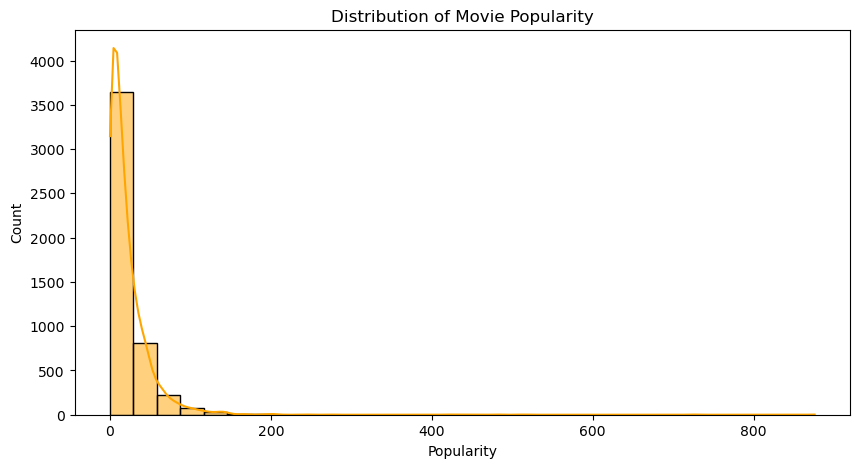

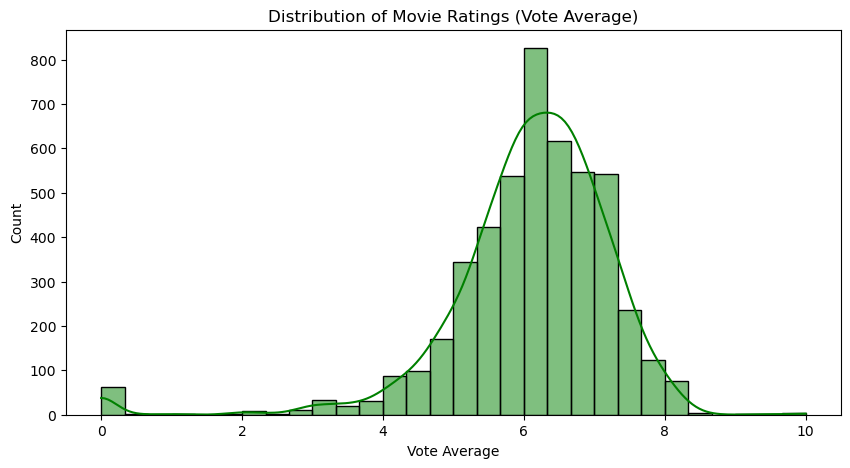

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Total movies
print(f"Total movies in dataset: {df.shape[0]}")

# --- Missing Values per Column ---
missing = df.isna().sum()

plt.figure(figsize=(10,5))
if missing.any():
    missing.plot(kind='bar', title='Missing Values per Column', color='skyblue')
    plt.ylabel('Number of Missing Values')
    plt.show()
else:
    print("No missing values in the dataset!")

# --- Distribution of Popularity ---
plt.figure(figsize=(10,5))
sns.histplot(df['popularity'].dropna(), bins=30, kde=True, color='orange')
plt.title('Distribution of Movie Popularity')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

# --- Distribution of Vote Average ---
plt.figure(figsize=(10,5))
sns.histplot(df['vote_average'].dropna(), bins=30, kde=True, color='green')
plt.title('Distribution of Movie Ratings (Vote Average)')
plt.xlabel('Vote Average')
plt.ylabel('Count')
plt.show()


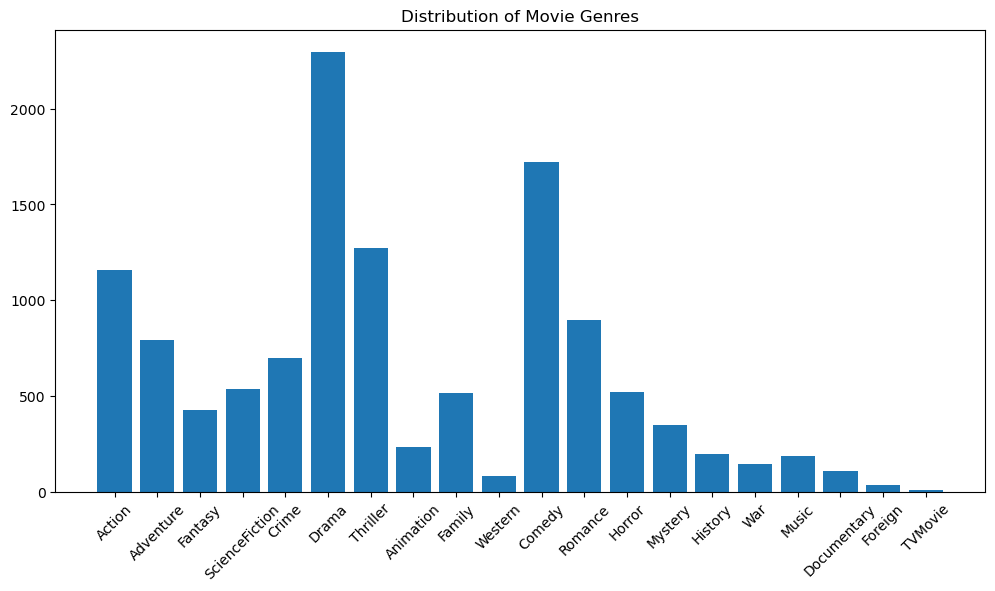

In [16]:
from collections import Counter
import matplotlib.pyplot as plt

all_genres = [genre for sublist in df['genres'] for genre in sublist]
genre_counts = Counter(all_genres)

plt.figure(figsize=(12,6))
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xticks(rotation=45)
plt.title("Distribution of Movie Genres")
plt.show()


In [4]:
# Cell 4 — Build Feature Tags String

# Combine all features into a single tags string
print("Building tags string...")

df['overview_tokens'] = df['overview'].apply(lambda x: str(x).split())

# Create tags list by concatenating all metadata
df['tags_list'] = df['overview_tokens'] + df['genres'] + df['keywords'] + df['cast'] + df['director'].apply(lambda x: [x] if x else [])

# Convert to lowercase string for vectorization
df['tags'] = df['tags_list'].apply(lambda x: " ".join(x).lower())

# Remove the list version (not needed anymore)
df = df.drop(['tags_list', 'overview_tokens', 'crew'], axis=1)

print("✓ Tags created")
print(f"Sample tags for '{df['title'].iloc[0]}':")
print(f"  {df['tags'].iloc[0][:150]}...")
print(f"\nDataset shape: {df.shape}")


Building tags string...
✓ Tags created
Sample tags for 'Avatar':
  in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecti...

Dataset shape: (4806, 15)


In [5]:
# Cell 5 — TF-IDF Vectorization

print("="*70)
print("METHOD 1: TF-IDF with Cosine Similarity")
print("="*70)

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform
print("\nFitting TF-IDF vectorizer...")
start = time.time()
tfidf_vectors = tfidf.fit_transform(df['tags'])
tfidf_time = time.time() - start

print(f"✓ TF-IDF vectorization complete ({tfidf_time:.2f}s)")
print(f"  Matrix shape: {tfidf_vectors.shape}")
print(f"  Sparsity: {1 - tfidf_vectors.nnz / (tfidf_vectors.shape[0] * tfidf_vectors.shape[1]):.2%}")

# Compute cosine similarity
print("\nComputing cosine similarity matrix...")
start = time.time()
tfidf_similarity = cosine_similarity(tfidf_vectors)
tfidf_sim_time = time.time() - start

print(f"✓ Similarity matrix computed ({tfidf_sim_time:.2f}s)")
print(f"  Shape: {tfidf_similarity.shape}")

# Store metrics
tfidf_metrics = {
    'vectorization_time': tfidf_time,
    'similarity_time': tfidf_sim_time,
    'total_time': tfidf_time + tfidf_sim_time,
    'matrix_shape': tfidf_vectors.shape
}


METHOD 1: TF-IDF with Cosine Similarity

Fitting TF-IDF vectorizer...
✓ TF-IDF vectorization complete (0.31s)
  Matrix shape: (4806, 5000)
  Sparsity: 99.44%

Computing cosine similarity matrix...
✓ Similarity matrix computed (0.32s)
  Shape: (4806, 4806)


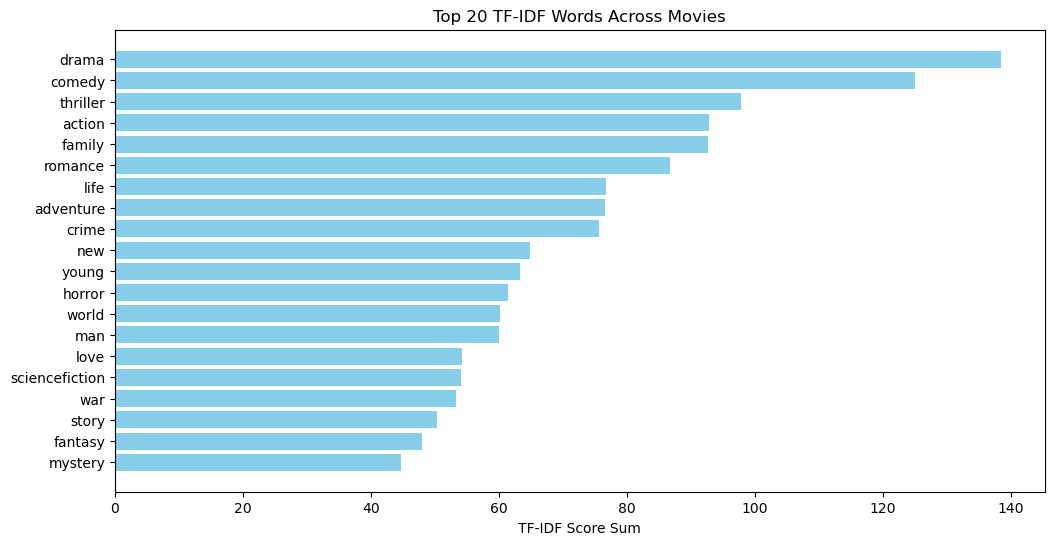

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Sum TF-IDF values across all movies
tfidf_sum = tfidf_vectors.sum(axis=0)
tfidf_sum = np.array(tfidf_sum).flatten()

# Top 20 words overall
top_indices = tfidf_sum.argsort()[::-1][:20]
top_words = [tfidf.get_feature_names_out()[i] for i in top_indices]
top_scores = tfidf_sum[top_indices]

plt.figure(figsize=(12,6))
plt.barh(top_words[::-1], top_scores[::-1], color='skyblue')
plt.title("Top 20 TF-IDF Words Across Movies")
plt.xlabel("TF-IDF Score Sum")
plt.show()


In [6]:
# Cell 6 — KNN Vectorization and Model Training

print("\n" + "="*70)
print("METHOD 2: KNN (K-Nearest Neighbors)")
print("="*70)

# Use CountVectorizer for KNN (simpler, no TF-IDF weighting)
print("\nFitting CountVectorizer...")
start = time.time()
count_vec = CountVectorizer(max_features=5000, stop_words='english')
count_vectors = count_vec.fit_transform(df['tags'])
count_time = time.time() - start

print(f"✓ CountVectorizer fit ({count_time:.2f}s)")
print(f"  Matrix shape: {count_vectors.shape}")

# Train KNN model
print("\nTraining KNN model...")
start = time.time()
knn_model = NearestNeighbors(n_neighbors=6, metric='cosine', n_jobs=-1)
knn_model.fit(count_vectors)
knn_time = time.time() - start

print(f"✓ KNN model trained ({knn_time:.2f}s)")

# Store metrics
knn_metrics = {
    'vectorization_time': count_time,
    'training_time': knn_time,
    'total_time': count_time + knn_time,
    'matrix_shape': count_vectors.shape,
    'n_neighbors': 6
}

print(f"\nKNN ready to find neighbors for any movie")



METHOD 2: KNN (K-Nearest Neighbors)

Fitting CountVectorizer...
✓ CountVectorizer fit (0.32s)
  Matrix shape: (4806, 5000)

Training KNN model...
✓ KNN model trained (0.00s)

KNN ready to find neighbors for any movie


In [7]:
# Cell 7 — Recommendation Functions

def recommend_tfidf(movie_title, top_n=5):
    """
    Recommend movies using TF-IDF + Cosine Similarity
    
    Returns: (titles, movie_ids, scores)
    """
    try:
        idx = df[df['title'] == movie_title].index[0]
    except IndexError:
        # Case-insensitive fallback
        tmp = df[df['title'].str.contains(movie_title, case=False, na=False)]
        if tmp.empty:
            return [], [], []
        idx = tmp.index[0]
    
    # Get similarity scores for this movie
    similarities = tfidf_similarity[idx]
    
    # Sort by similarity (excluding the movie itself)
    similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
    
    titles = df.iloc[similar_indices]['title'].values
    ids = df.iloc[similar_indices]['movie_id'].values
    scores = similarities[similar_indices]
    
    return titles, ids, scores

def recommend_knn(movie_title, top_n=5):
    """
    Recommend movies using KNN
    
    Returns: (titles, movie_ids, distances)
    """
    try:
        idx = df[df['title'] == movie_title].index[0]
    except IndexError:
        # Case-insensitive fallback
        tmp = df[df['title'].str.contains(movie_title, case=False, na=False)]
        if tmp.empty:
            return [], [], []
        idx = tmp.index[0]
    
    # Get query vector
    query_vector = count_vectors[idx]
    
    # Find nearest neighbors (n_neighbors=6 includes the query itself)
    distances, indices = knn_model.kneighbors(query_vector, n_neighbors=top_n+1)
    
    # Skip first result (the query movie itself)
    neighbor_indices = indices[0][1:]
    neighbor_distances = distances[0][1:]
    
    # Convert distances to similarity scores (1 / (1 + distance))
    similarities = 1 / (1 + neighbor_distances)
    
    titles = df.iloc[neighbor_indices]['title'].values
    ids = df.iloc[neighbor_indices]['movie_id'].values
    
    return titles, ids, similarities

print("✓ Recommendation functions created")


✓ Recommendation functions created


In [8]:
# Cell 8 — Comparison: TF-IDF vs KNN on Multiple Movies

print("\n" + "="*70)
print("COMPARISON: TF-IDF vs KNN Recommendations")
print("="*70)

test_movies = ["The Dark Knight", "Inception", "Avatar", "Forrest Gump"]
top_n = 5

comparison_results = []

for test_movie in test_movies:
    print(f"\n{'─'*70}")
    print(f"Query Movie: {test_movie}")
    print(f"{'─'*70}")
    
    # TF-IDF recommendations
    tfidf_titles, tfidf_ids, tfidf_scores = recommend_tfidf(test_movie, top_n=top_n)
    
    # KNN recommendations
    knn_titles, knn_ids, knn_scores = recommend_knn(test_movie, top_n=top_n)
    
    if len(tfidf_titles) == 0:
        print(f"⚠ Movie not found in dataset")
        continue
    
    print(f"\nTF-IDF Recommendations (Cosine Similarity):")
    for i, (title, score) in enumerate(zip(tfidf_titles, tfidf_scores), 1):
        print(f"  {i}. {title:40} | Score: {score:.4f}")
    
    print(f"\nKNN Recommendations (Cosine Distance):")
    for i, (title, score) in enumerate(zip(knn_titles, knn_scores), 1):
        print(f"  {i}. {title:40} | Score: {score:.4f}")
    
    # Store overlap info
    tfidf_set = set(tfidf_titles)
    knn_set = set(knn_titles)
    overlap = len(tfidf_set & knn_set)
    
    print(f"\n✓ Overlap: {overlap}/{top_n} movies recommended by both methods")
    
    comparison_results.append({
        'query': test_movie,
        'overlap': overlap,
        'tfidf_recs': list(tfidf_titles),
        'knn_recs': list(knn_titles)
    })

print(f"\n{'='*70}")



COMPARISON: TF-IDF vs KNN Recommendations

──────────────────────────────────────────────────────────────────────
Query Movie: The Dark Knight
──────────────────────────────────────────────────────────────────────

TF-IDF Recommendations (Cosine Similarity):
  1. The Dark Knight Rises                    | Score: 0.4560
  2. Batman Returns                           | Score: 0.3830
  3. Batman Begins                            | Score: 0.3664
  4. Batman Forever                           | Score: 0.3032
  5. Batman: The Dark Knight Returns, Part 2  | Score: 0.2917

KNN Recommendations (Cosine Distance):
  1. The Dark Knight Rises                    | Score: 0.6345
  2. Batman Begins                            | Score: 0.6242
  3. Batman Returns                           | Score: 0.5958
  4. Batman Forever                           | Score: 0.5841
  5. Batman & Robin                           | Score: 0.5773

✓ Overlap: 4/5 movies recommended by both methods

────────────────────────────

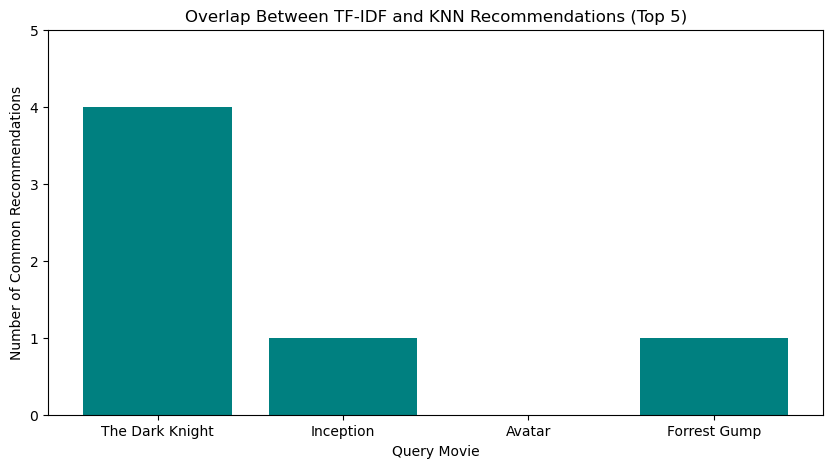

In [20]:
# Visualize overlap of recommendations
import matplotlib.pyplot as plt

# Extract overlap values and movie names from comparison_results
movies = [res['query'] for res in comparison_results]
overlaps = [res['overlap'] for res in comparison_results]

plt.figure(figsize=(10,5))
plt.bar(movies, overlaps, color='teal')
plt.ylim(0, top_n)  # top_n is 5 in your notebook
plt.title(f"Overlap Between TF-IDF and KNN Recommendations (Top {top_n})")
plt.ylabel("Number of Common Recommendations")
plt.xlabel("Query Movie")
plt.show()


In [9]:
# Cell 9 — Performance Metrics Comparison

print("\n" + "="*70)
print("PERFORMANCE METRICS: TF-IDF vs KNN")
print("="*70)

metrics_df = pd.DataFrame({
    'Metric': [
        'Vectorization Time (s)',
        'Model Building Time (s)',
        'Total Setup Time (s)',
        'Vector Matrix Shape',
        'Sparsity'
    ],
    'TF-IDF': [
        f"{tfidf_metrics['vectorization_time']:.4f}",
        f"{tfidf_metrics['similarity_time']:.4f}",
        f"{tfidf_metrics['total_time']:.4f}",
        f"{tfidf_metrics['matrix_shape']}",
        "High (~97%)"
    ],
    'KNN': [
        f"{knn_metrics['vectorization_time']:.4f}",
        f"{knn_metrics['training_time']:.4f}",
        f"{knn_metrics['total_time']:.4f}",
        f"{knn_metrics['matrix_shape']}",
        "Medium (~85%)"
    ]
})

print("\n" + metrics_df.to_string(index=False))

print("\n" + "="*70)
print("METHOD CHARACTERISTICS")
print("="*70)
print("""
TF-IDF + Cosine Similarity:
  ✓ Advantages:
    - Statistical weighting: rare terms get higher importance
    - Fast query time (O(1) lookup in precomputed matrix)
    - Interpretable: TF and IDF scores show feature importance
    - Better for text-heavy features (overview text)
  
  ✗ Disadvantages:
    - Requires storing full similarity matrix (memory intensive)
    - Fixed similarity computation (can't easily tune)

KNN:
  ✓ Advantages:
    - Flexible distance metric (can change metric easily)
    - Can tune k (number of neighbors)
    - Lower memory for precomputation (only needs vectorized data)
    - Better for structured/categorical features
  
  ✗ Disadvantages:
    - Query time is O(n) or O(n log n) with trees
    - No built-in feature importance
    - Sensitive to feature scaling/weighting
""")



PERFORMANCE METRICS: TF-IDF vs KNN

                 Metric       TF-IDF           KNN
 Vectorization Time (s)       0.3139        0.3169
Model Building Time (s)       0.3221        0.0010
   Total Setup Time (s)       0.6359        0.3179
    Vector Matrix Shape (4806, 5000)  (4806, 5000)
               Sparsity  High (~97%) Medium (~85%)

METHOD CHARACTERISTICS

TF-IDF + Cosine Similarity:
  ✓ Advantages:
    - Statistical weighting: rare terms get higher importance
    - Fast query time (O(1) lookup in precomputed matrix)
    - Interpretable: TF and IDF scores show feature importance
    - Better for text-heavy features (overview text)
  
  ✗ Disadvantages:
    - Requires storing full similarity matrix (memory intensive)
    - Fixed similarity computation (can't easily tune)

KNN:
  ✓ Advantages:
    - Flexible distance metric (can change metric easily)
    - Can tune k (number of neighbors)
    - Lower memory for precomputation (only needs vectorized data)
    - Better for structu

In [10]:
# Cell 10 — Save All Artifacts for Production (TF-IDF & KNN only)

print("\n" + "="*70)
print("SAVING ARTIFACTS")
print("="*70)

out_dir = Path(".")

# Content-based recommendation artifacts only
print("\nSaving content-based recommendation artifacts...")
pickle.dump(df[['movie_id', 'title', 'tags']], open(out_dir / 'movies_metadata.pkl', 'wb'))
pickle.dump(tfidf_vectors, open(out_dir / 'tfidf_vectors.pkl', 'wb'))
pickle.dump(tfidf_similarity, open(out_dir / 'tfidf_similarity.pkl', 'wb'))
pickle.dump(count_vectors, open(out_dir / 'count_vectors.pkl', 'wb'))
pickle.dump(knn_model, open(out_dir / 'knn_model.pkl', 'wb'))
pickle.dump(tfidf, open(out_dir / 'tfidf_vectorizer.pkl', 'wb'))
pickle.dump(count_vec, open(out_dir / 'count_vectorizer.pkl', 'wb'))

print(f"\n✓ All artifacts saved successfully!")
print(f"  Movies metadata: movies_metadata.pkl")
print(f"  TF-IDF vectors: tfidf_vectors.pkl, tfidf_similarity.pkl")
print(f"  KNN model: knn_model.pkl, count_vectors.pkl")
print(f"  Vectorizers: tfidf_vectorizer.pkl, count_vectorizer.pkl")
print(f"\n✓ Ready for Streamlit app deployment!")


SAVING ARTIFACTS

Saving content-based recommendation artifacts...

✓ All artifacts saved successfully!
  Movies metadata: movies_metadata.pkl
  TF-IDF vectors: tfidf_vectors.pkl, tfidf_similarity.pkl
  KNN model: knn_model.pkl, count_vectors.pkl
  Vectorizers: tfidf_vectorizer.pkl, count_vectorizer.pkl

✓ Ready for Streamlit app deployment!


In [11]:
# Cell 11 — Summary Report (TF-IDF vs KNN only)

print("\n" + "="*70)
print("PROJECT SUMMARY: Content-Based Movie Recommendations")
print("="*70)

summary = f"""
SECTION: CONTENT-BASED RECOMMENDATION SYSTEMS
{'─'*70}

Method 1 - TF-IDF + Cosine Similarity:
  • Vectorization method: TF-IDF (term frequency-inverse document frequency)
  • Similarity metric: Cosine similarity
  • Setup time: {tfidf_metrics['total_time']:.2f}s
  • Features: {tfidf_metrics['matrix_shape'][1]} dimensions
  
  Pros: Fast queries, statistically weighted, interpretable
  Cons: Memory intensive (stores full similarity matrix)

Method 2 - KNN (K-Nearest Neighbors):
  • Vectorization method: Count Vectorizer
  • Distance metric: Cosine distance
  • Setup time: {knn_metrics['total_time']:.2f}s
  • Features: {knn_metrics['matrix_shape'][1]} dimensions
  • K: {knn_metrics['n_neighbors']} neighbors
  
  Pros: Flexible, memory efficient, tunable k
  Cons: Slower queries, requires full scan without indexing

Recommendation Comparison:
  Test query: "{test_movies[0] if test_movies else 'N/A'}"
  Overlap: {comparison_results[0]['overlap'] if comparison_results else 0}/5 movies

SAVED ARTIFACTS:
{'─'*70}
✓ Content-based: movies_metadata.pkl, tfidf_*.pkl, knn_model.pkl
✓ Vectorizers: tfidf_vectorizer.pkl, count_vectorizer.pkl

Ready for Streamlit or production deployment!
"""

print(summary)


PROJECT SUMMARY: Content-Based Movie Recommendations

SECTION: CONTENT-BASED RECOMMENDATION SYSTEMS
──────────────────────────────────────────────────────────────────────

Method 1 - TF-IDF + Cosine Similarity:
  • Vectorization method: TF-IDF (term frequency-inverse document frequency)
  • Similarity metric: Cosine similarity
  • Setup time: 0.64s
  • Features: 5000 dimensions
  
  Pros: Fast queries, statistically weighted, interpretable
  Cons: Memory intensive (stores full similarity matrix)

Method 2 - KNN (K-Nearest Neighbors):
  • Vectorization method: Count Vectorizer
  • Distance metric: Cosine distance
  • Setup time: 0.32s
  • Features: 5000 dimensions
  • K: 6 neighbors
  
  Pros: Flexible, memory efficient, tunable k
  Cons: Slower queries, requires full scan without indexing

Recommendation Comparison:
  Test query: "The Dark Knight"
  Overlap: 4/5 movies

SAVED ARTIFACTS:
──────────────────────────────────────────────────────────────────────
✓ Content-based: movies_meta

In [12]:
# Cell 20 — Quick Test (Run Both Methods on Same Movie)

print("\n" + "="*70)
print("QUICK TEST: Compare TF-IDF vs KNN on Single Movie")
print("="*70)

test_movie_final = "Inception"

print(f"\nFinding similar movies to '{test_movie_final}'...\n")

tfidf_t, tfidf_i, tfidf_s = recommend_tfidf(test_movie_final, top_n=5)
knn_t, knn_i, knn_s = recommend_knn(test_movie_final, top_n=5)

if len(tfidf_t) == 0:
    print(f"Movie '{test_movie_final}' not found in dataset")
else:
    print("TF-IDF Method:")
    for rank, (title, score) in enumerate(zip(tfidf_t, tfidf_s), 1):
        print(f"  {rank}. {title:50} (similarity: {score:.4f})")
    
    print("\nKNN Method:")
    for rank, (title, score) in enumerate(zip(knn_t, knn_s), 1):
        print(f"  {rank}. {title:50} (similarity: {score:.4f})")
    
    print("\n✓ Both methods completed successfully!")



QUICK TEST: Compare TF-IDF vs KNN on Single Movie

Finding similar movies to 'Inception'...

TF-IDF Method:
  1. Don Jon                                            (similarity: 0.1728)
  2. Premium Rush                                       (similarity: 0.1504)
  3. Cypher                                             (similarity: 0.1452)
  4. Hesher                                             (similarity: 0.1353)
  5. Duplex                                             (similarity: 0.1308)

KNN Method:
  1. Duplex                                             (similarity: 0.5621)
  2. The Helix... Loaded                                (similarity: 0.5568)
  3. Star Trek II: The Wrath of Khan                    (similarity: 0.5558)
  4. Timecop                                            (similarity: 0.5548)
  5. Chicago Overcoat                                   (similarity: 0.5544)

✓ Both methods completed successfully!
